# Part 1: Feedforward Neural Networks on CIFAR-10

Part 1, the process of training a model for CIFAR-10, has been split into notebooks 1 to 3.

CIFAR-10 is a fundamental machine learning dataset containing 60,000 32x32 pixel color images across 10 distinct classes. It consists of 50,000 training images and 10,000 testing images, widely used for benchmarking computer vision models.

This notebook showcases an initial attempt at solving the CIFAR-10 classification problem using a simple feedforward neural network and explores the effectiveness of the model, to prove the hypothesis that FFNNs are poorly suited for image classification tasks.

 ## Environment Setup and Data Preparation

The 10 classes in CIFAR-10 are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. They are predefined in `utils.py` as `cifar10_classes` for reference.

Torchvision automatically handles the download and preprocessing of the CIFAR-10 dataset into train, evaluation, and test subsets consisting of 50,000, 5,000, and 5,000 images respectively. The subsets are then wrapped as DataLoaders for efficient batch processing.

For now, this is done without data augmentation (a common technique of inducing randomness on the data to improve a model's robustness and generalization).

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pandas as pd
import utils
import copy
import itertools

In [8]:
# Download training and test sets
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
full_test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

val_data = torch.utils.data.Subset(full_test_data, indices=list(range(5000)))
test_data = torch.utils.data.Subset(full_test_data, indices=list(range(5000, 10000)))

# Create DataLoaders
trainloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2) # workers=2 for parallel data loading
valloader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

## Initial Model Definition

We define here a feedforward neural network, using Pytorch, of the following architecture:
* Input: 3072 $(32 \times 32 \times 3)$ input features ($32 \times 32$ pixels, each pixel having $3$ channels for RGB color).
* Hidden layer: 128 neurons, with ReLU activation function.
* Output: 10 neurons corresponding to the 10 classes in CIFAR-10, with Softmax activation function.

Changes to the architecture are explored further down this notebook.

ReLU is chosen as the standard activation function for hidden layers as it is known to introduce non-linearity and help the model learn complex patterns. Softmax is used for the output layer to turn predictions into a probabilities vector for the classes.

To feed the model an image from the dataset, we need to flatten it to a single vector of 3072 features. This is because the model expects a 1D input vector, but the images are 3D tensors (height, width, channels). This is why `nn.Flatten()` is used on the input before the forward pass.

In [9]:
class BaselineFFNN(nn.Module):
    def __init__(self):
        super(BaselineFFNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3072, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x) # Flatten the input tensor to a 1D vector
        x = F.relu(self.fc1(x)) # ReLU activation function
        x = self.fc2(x) # PyTorch's CrossEntropyLoss applies Softmax internally, so no need to apply it explicitly
        return x

## Training

The model training process is implemented in `utils.py` in a standardized manner as `simple_train_model`.

The training loop iterates over the dataset multiple times (epochs). In each iteration it performs a forward pass on the model, computes the loss using a given criterion, and updates the model's weights using the specified optimizer. This process is crucial for the model to learn from the data and improve its performance over time.

The Loss Function and the Gradient Descent's Optimization are defined for the training process. Changes to them for the purpose of improvement are explored further down this notebook.

### Loss Function
We use CrossEntropyLoss as the criterion as it is a standard choice for multi-class classification problems. It computes the negative log-likelihood of the true class given the model's predicted probabilities.

For a multi-class classification problem with $C$ classes, the Cross-Entropy Loss for a single observation is calculated as:

$$L = -\sum_{c=1}^{C} y_{c} \log(\hat{y}_{c})$$

**Where:**
* $y_{c}$ is the **ground truth** (1 if $c$ is the correct class, 0 otherwise).
* $\hat{y}_{c}$ is the **predicted probability** for class $c$, calculated via the Softmax function:

$$\hat{y}_{c} = \frac{e^{x_c}}{\sum_{j=1}^{C} e^{x_j}}$$

### Optimization
We use Stochastic Gradient Descent (SGD) with a learning rate ($\eta$ or `lr`) of 0.001 as the optimizer.

A momentum ($\mu$) of 0.9 is used to accelerate convergence and reduce oscillations during training, as it helps the model converge smoothly by retaining information from previous iterations.

SGD with momentum updates the weights of the model after each iteration as follows:
$$w_{t+1} = w_t - \eta \frac{\partial L}{\partial w} + \eta \cdot \mu \frac{\partial L}{\partial v}$$
$$v_{t+1} = \mu v_t - \eta \frac{\partial L}{\partial w}$$
Where $v$ is the velocity term, which accumulates the gradients over time. This helps the gradients converge around the optimal point and reduces the risk of overshooting the minimum.

There is no need to implement the loss functions and optimizers as they are already provided by PyTorch.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Check if a GPU is available for training
baseline_model = BaselineFFNN().to(device) # Define the model
crossEntropy_criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.001, momentum=0.9)

### Mid-Training Evaluation
The evaluation process is done during the training loop to assess the model's performance on unseen data. For this reason the full test dataset was split to test and validation subsets.

Evaluation is done by computing the loss and accuracy. By tracking the loss and accuracy on the validation subset over time, we can monitor the model's performance and make adjustments to improve it. The test subset is later used to assess the final performance of the trained model.

In [11]:
def evaluate(model, testloader, criterion, device):
    model.eval()  # Set to evaluation mode (turns off Dropout/BatchNorm)
    test_loss = 0
    correct = 0
    with torch.no_grad():  # No gradient calculation saved (saves memory)
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()

    loss = test_loss / len(testloader)
    acc = 100. * correct / len(testloader.dataset)
    return loss, acc

#### Train Function
This function includes early stopping functionality to prevent overfitting to the training data. This will be utilized later, once it is shown that overfitting causes validation accuracy to plateau or decrease while training accuracy continues to improve.

The train function returns the history of loss and accuracy for both training and validation sets, allowing for monitoring of model performance during training.

In [12]:
def train_FFNN(model, trainloader, valloader, criterion, optimizer, device, epochs=5,
               console=False, early_stopping=False, patience=3):
    model.to(device)
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    best_val_loss = float('inf') # For early stopping
    best_model_wts = copy.deepcopy(model.state_dict())
    no_improvement_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Calculate epoch metrics
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        epoch_val_loss, epoch_val_acc = evaluate(model, valloader, criterion, device)

        # Save to history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        if console:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
                  f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%")

        if early_stopping:
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                # Save the best model weights
                best_model_wts = copy.deepcopy(model.state_dict())
                no_improvement_counter = 0 # Reset counter
            else:
                no_improvement_counter += 1
                if console: print(f"  EarlyStopping counter: {no_improvement_counter} out of {patience}")

                if no_improvement_counter >= patience:
                    if console: print("Early stopping triggered! Restoring best weights...")
                    model.load_state_dict(best_model_wts) # Restore best model
                    break

    if console: print("Finished Training")
    return history

train_results = train_FFNN(baseline_model, trainloader, valloader, crossEntropy_criterion, optimizer, device, epochs=10, console=True)

Epoch 1/10 | Train Loss: 2.0297 | Train Acc: 27.98% | Val Loss: 1.8834 | Val Acc: 34.46%
Epoch 2/10 | Train Loss: 1.8467 | Train Acc: 35.45% | Val Loss: 1.7950 | Val Acc: 37.72%
Epoch 3/10 | Train Loss: 1.7727 | Train Acc: 37.97% | Val Loss: 1.7288 | Val Acc: 39.96%
Epoch 4/10 | Train Loss: 1.7174 | Train Acc: 39.82% | Val Loss: 1.6829 | Val Acc: 41.46%
Epoch 5/10 | Train Loss: 1.6744 | Train Acc: 41.39% | Val Loss: 1.6559 | Val Acc: 41.78%
Epoch 6/10 | Train Loss: 1.6394 | Train Acc: 42.52% | Val Loss: 1.6070 | Val Acc: 44.12%
Epoch 7/10 | Train Loss: 1.6072 | Train Acc: 43.87% | Val Loss: 1.5927 | Val Acc: 44.58%
Epoch 8/10 | Train Loss: 1.5840 | Train Acc: 44.74% | Val Loss: 1.5729 | Val Acc: 44.62%
Epoch 9/10 | Train Loss: 1.5616 | Train Acc: 45.54% | Val Loss: 1.5528 | Val Acc: 46.10%
Epoch 10/10 | Train Loss: 1.5434 | Train Acc: 46.17% | Val Loss: 1.5756 | Val Acc: 44.42%
Finished Training


## Post-Training Evaluation

By examining the plotted loss and accuracy curves, we can assess the model's performance and make adjustments to improve it. The validation subset is used to evaluate the model's performance during training, while the test subset is used to assess the final performance of the trained model.

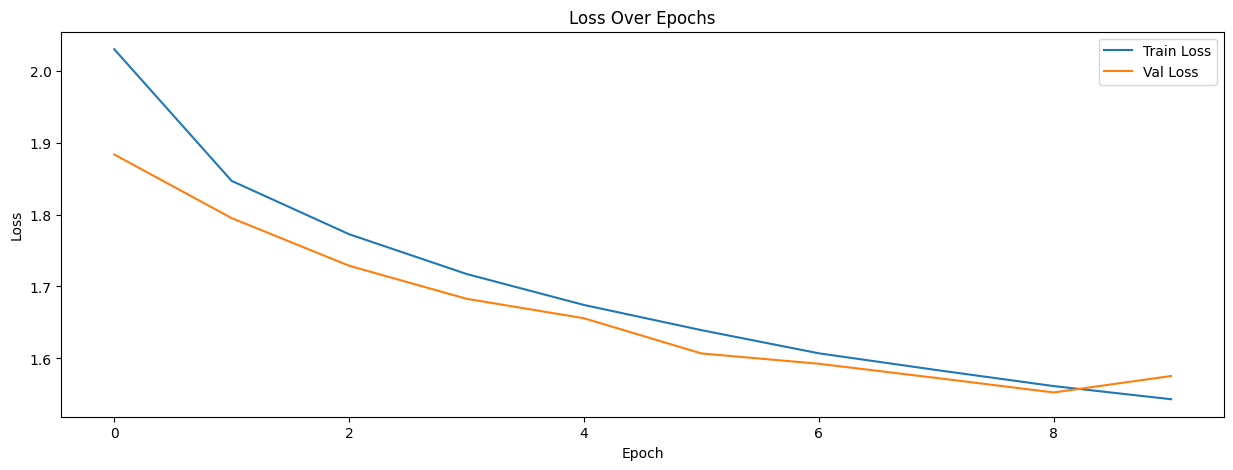

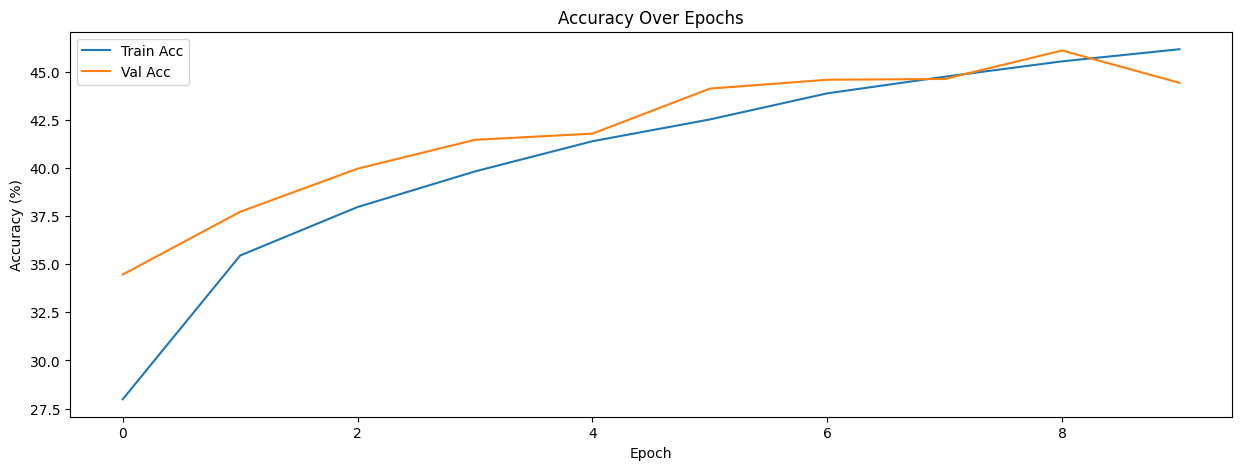

In [13]:
utils.plot_loss(train_results['train_loss'], train_results['val_loss'])
utils.plot_acc(train_results['train_acc'], train_results['val_acc'])

These results show that the validation accuracy improved alongside training accuracy, but it plateaus around 44%, and the loss plateaus at the same time. This indicates that the model reached a ceiling and is not capable of further learning with the current architecture. Improvement may require exploration of different hyperparameters, regularization techniques, or entirely different architectures.

This can also be confirmed on the testing set:

In [14]:
_, acc = evaluate(baseline_model, testloader, crossEntropy_criterion, device)
print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 43.54%


## Further Exploration

### Model Architecture Tuning
The model architecture can be further explored by changing the number of neurons in the hidden layer. This may be beneficial since the results indicate that the model may not be large enough to sufficiently generalize the CIFAR-10 dataset. We will experiment with the following configurations of hidden layers:
* **Baseline**: Input(3072) -> 128 -> Output(10)
* **Small**: Input(3072) -> 512 -> Output(10)
* **Medium**: Input(3072) -> 512 -> 256 -> Output(10)
* **Large**: Input(3072) -> 1024 -> 512 -> 256 -> Output(10)
* **Deep**: Input(3072) -> [512] x 5 layers -> 256 -> Output(10)

It should be noted that the size of the hidden layers is always chosen to be a power of 2 as this has been shown to improve performance due to the hardware structure.

In [15]:
# Flexible class for a custom-sized feedforward neural network
class FlexibleFFNN(nn.Module):
    def __init__(self, hidden_sizes):
        super().__init__()
        self.flatten = nn.Flatten()
        layers = []
        a = 3072 # Input size of the flattened image tensor from CIFAR-10

        for n in hidden_sizes:
            layers.append(nn.Linear(a, n))
            layers.append(nn.ReLU())
            a = n

        layers.append(nn.Linear(a, 10)) # Output layer
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(self.flatten(x))

#### Training

In [16]:
# Predefined models
models = {
    'Small': FlexibleFFNN([256]).to(device),
    'Medium': FlexibleFFNN([512, 256]).to(device),
    'Large': FlexibleFFNN([1024, 512, 256]).to(device),
    'Deep': FlexibleFFNN([512, 512, 512, 512, 256]).to(device)
}

results_data = []
histories = dict()

# Training for each model
for name, model in models.items():
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    history = train_FFNN(model, trainloader, valloader, crossEntropy_criterion, optimizer, device, epochs=10)

    final_train = history['train_acc'][-1]
    final_val = history['val_acc'][-1]
    results_data.append({
        'Model': name,
        'Train Acc': final_train,
        'Val Acc': final_val,
        'Gap': final_train - final_val
    })
    histories[name] = history

    print(f"{name:<10} | Train Acc: {final_train:.2f}% | Val Acc: {final_val:.2f}%")

Small      | train acc: 49.07    % | val acc: 46.42    %
Medium     | train acc: 52.95    % | val acc: 49.74    %
Large      | train acc: 53.21    % | val acc: 50.76    %
Deep       | train acc: 52.19    % | val acc: 48.50    %


#### Results

,Model,Train Acc,Val Acc,Gap
0,Small,49.072,46.42,2.652
1,Medium,52.952,49.74,3.212
2,Large,53.212,50.76,2.452
3,Deep,52.186,48.50,3.686


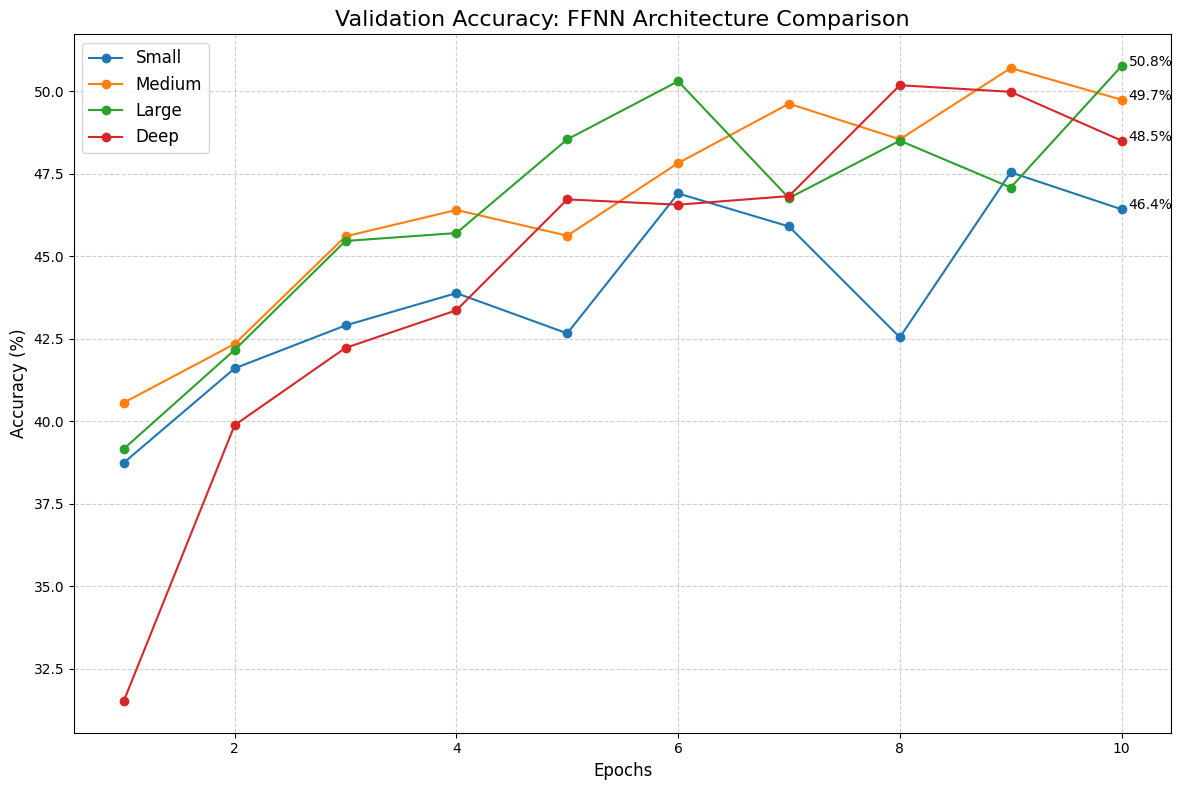

In [17]:
df_results = pd.DataFrame(results_data)
display(df_results)
utils.plot_validation_curves(histories)

The results show that the performance of all models plateaus below 50%. Examining the two largest models can reveal whether there is room for improvement.

#### Large Sized Model Autopsy

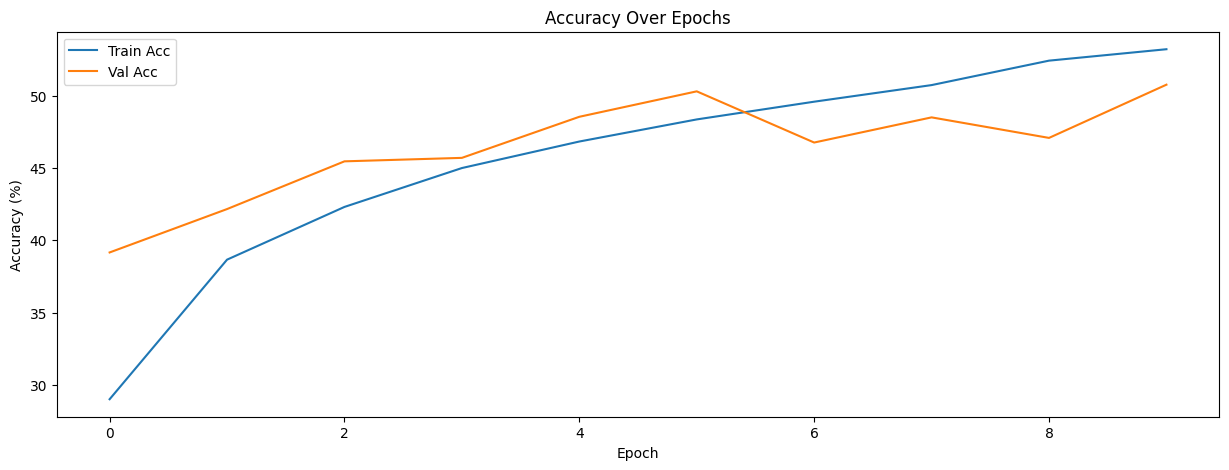

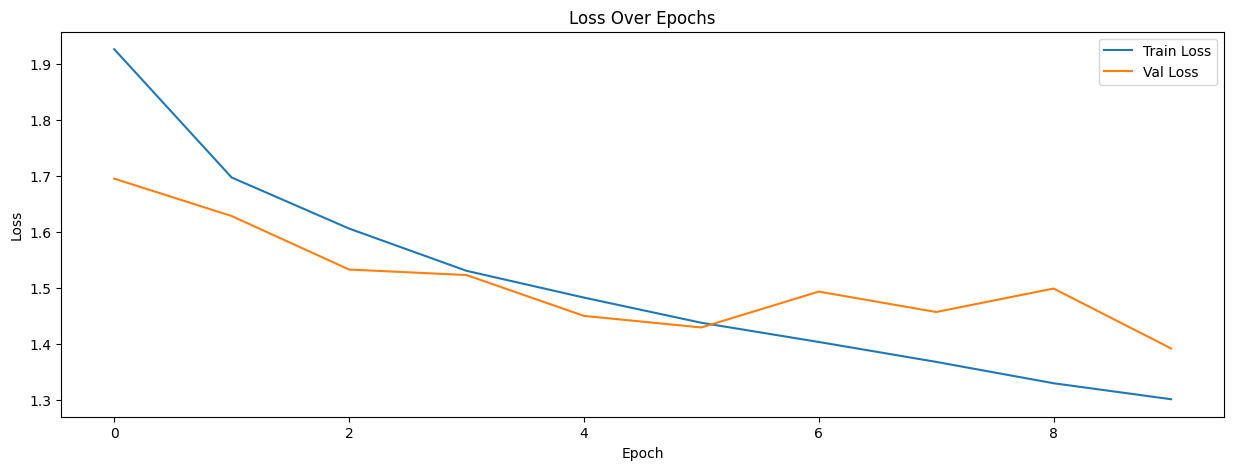

In [26]:
utils.plot_acc(histories['Large']['train_acc'], histories['Large']['val_acc'])
utils.plot_loss(histories['Large']['train_loss'], histories['Large']['val_loss'])

#### Deep Sized Model Autopsy

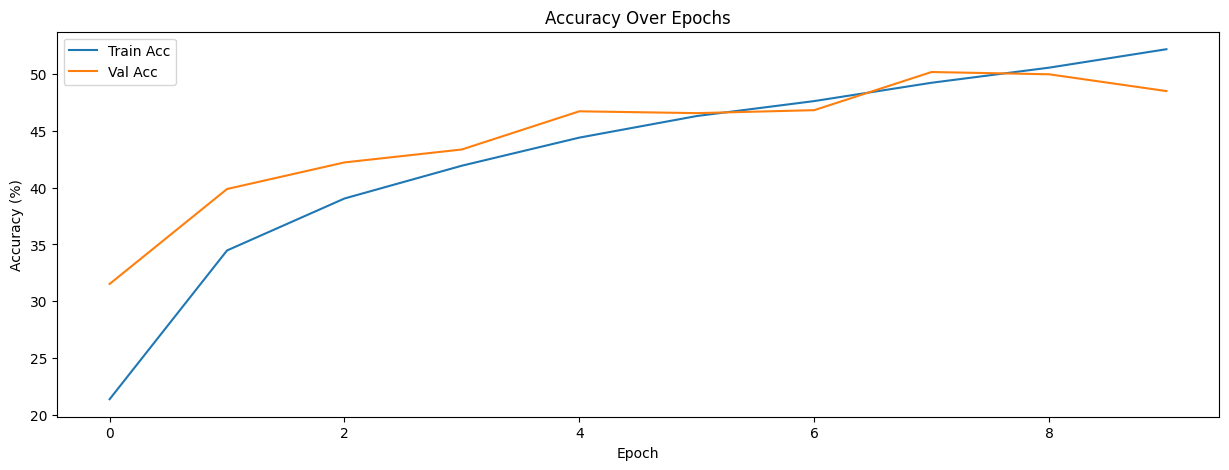

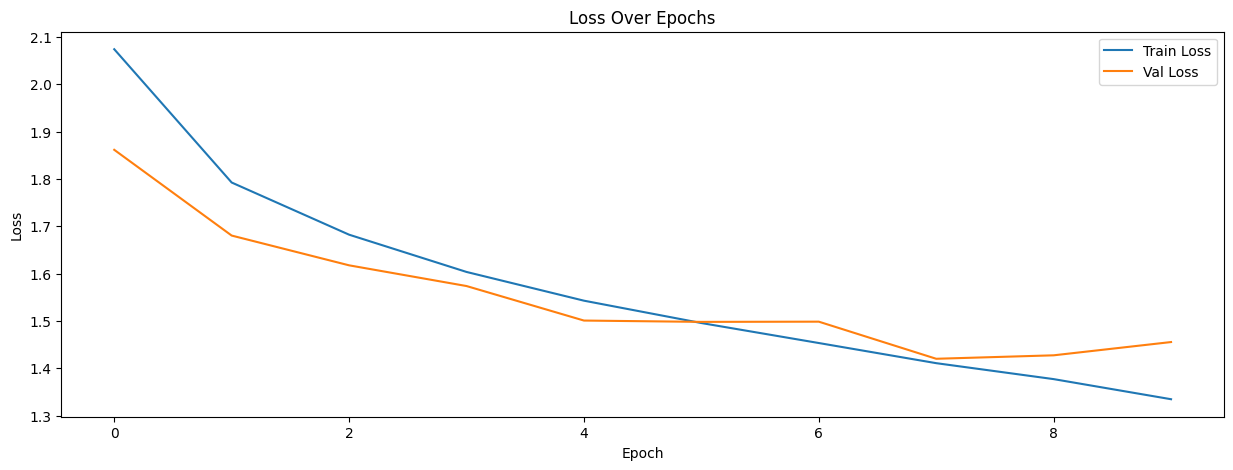

In [27]:
utils.plot_acc(histories['Deep']['train_acc'], histories['Deep']['val_acc'])
utils.plot_loss(histories['Deep']['train_loss'], histories['Deep']['val_loss'])

Examining the accuracy curves reveals that the model underfits significantly: it fails to capture the complex patterns in the data, even in its training subset, reaching below 50% accuracy.

We can attempt to remedy this by replacing the optimizer from SGD to Adam. Adam optimizer has built in adaptive momentum and RMSProp, which helps mitigate the issue of vanishing gradients that is common with SGD. There is further potential in sweeping across learning rate values to find an optimal one for the model.

In addition, we can increase the number of epochs to 20 and introduce early stopping in case the model starts overfitting.

Adam is defined by two momentum terms $\beta_1$ and $\beta_2$, which control the exponential decay of the first and second moments of the gradients respectively:
$$
\begin{aligned}
g_t &= \nabla_\theta L(\theta_{t-1}) & \text{(Gradient)} \\
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t & \text{(1st Moment Vector)} \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 & \text{(2nd Moment Vector)} \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} & \text{(Bias Correction)} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} & \text{(Bias Correction)} \\
\theta_t &= \theta_{t-1} - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t & \text{(Parameter Update)}
\end{aligned}
$$


#### Training with Adam Optimizer

In [28]:
model = FlexibleFFNN([1024, 512, 256]).to(device) # Large model
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
histories = train_FFNN(model, trainloader, valloader, crossEntropy_criterion, optimizer, device,
                     epochs=20, early_stopping=True)

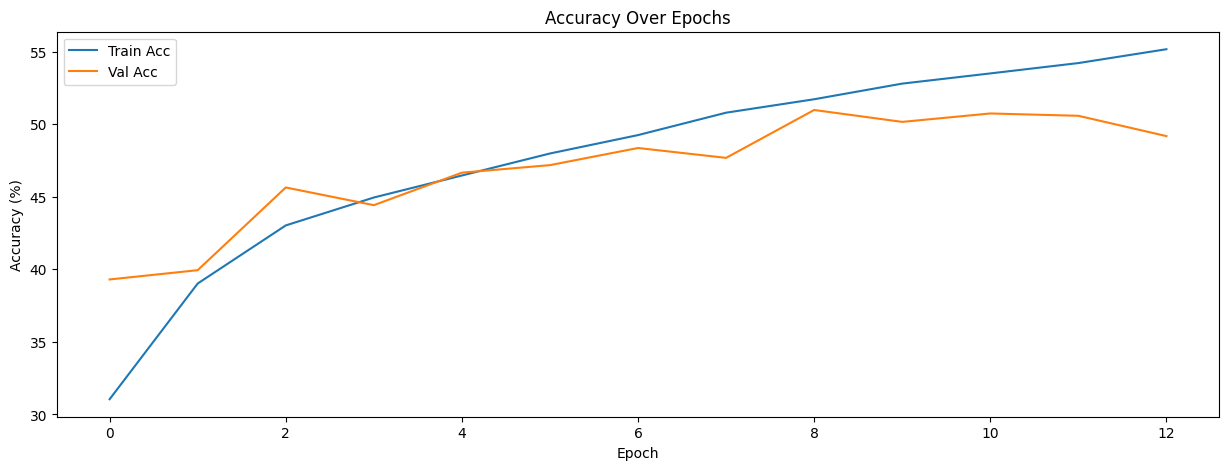

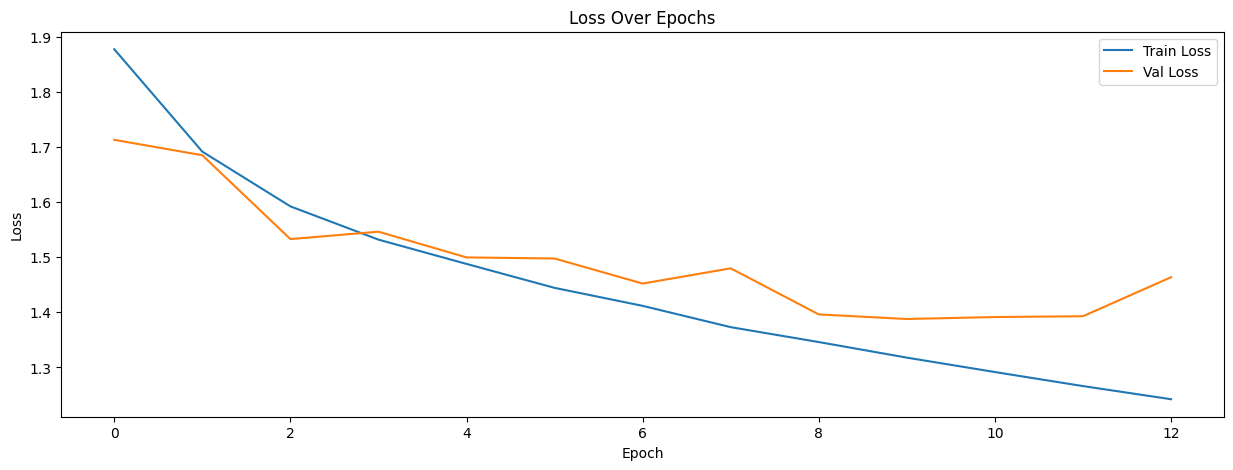

In [29]:
utils.plot_acc(histories['train_acc'], histories['val_acc'])
utils.plot_loss(histories['train_loss'], histories['val_loss'])

The training curves reveal that the model fails to generalize, with the validation accuracy still stagnating around 45%, while the training accuracy rises to around 55%. This indicates high Bias: the model fails to generalize even on its training data.

As the gap between the two curves starts to widen the training process is cut off (it reached 12 out of 20 iterations) which suggests that no further improvement can be made with more iterations.

However, it is possible that the two hyperparameters, learning rate and batch size, are not optimal for this model, which leads to it being stuck in local minima without reaching the optimum in the 'saddle point', which is often the case with deep neural networks. In an attempt to mitigate this, a grid search across the potential learning rates and batch sizes is performed to find an optimal combination.

#### Learning Rate & Batch Size Screening
A combination of learning rates and batch sizes is tested to find the optimal configuration for the FFNN model. In total this requires retraining the model 9 more times, which can take a while, so the number of iterations is reduced to 5 (this would be enough to indicate which combination of hyperparameters works best).

In [33]:
learning_rates = [0.001, 0.0001, 5e-5]
batch_sizes = [16, 32, 64]
results = []

for lr, batch_size in itertools.product(learning_rates, batch_sizes):
    # Re-create DataLoaders, model and optimizer
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
    model = FlexibleFFNN([512, 256]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train and log
    history = train_FFNN(model, trainloader, valloader, crossEntropy_criterion, optimizer, device,
                         epochs=5, early_stopping=True)
    best_val = max(history['val_acc'])
    print(f"{lr:<10} | {batch_size:<10} | {best_val:.2f}%")
    results.append({
        'lr': lr,
        'batch_size': batch_size,
        'val_acc': best_val,
        'history': history
    })

# Find the winner
best_config = max(results, key=lambda x: x['val_acc'])
print(f"\nBest Config: LR={best_config['lr']}, Batch={best_config['batch_size']}")

0.001      | 16         | 45.42%
0.001      | 32         | 46.90%
0.001      | 64         | 46.36%
0.0001     | 16         | 46.74%
0.0001     | 32         | 47.14%
0.0001     | 64         | 46.62%
5e-05      | 16         | 46.22%
5e-05      | 32         | 46.52%
5e-05      | 64         | 44.74%

Best Config: LR=0.0001, Batch=32


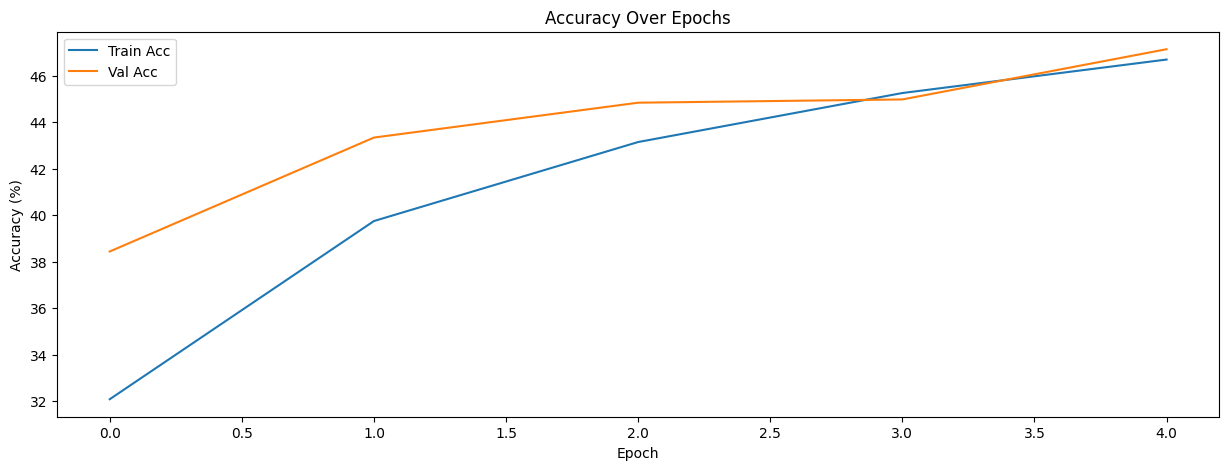

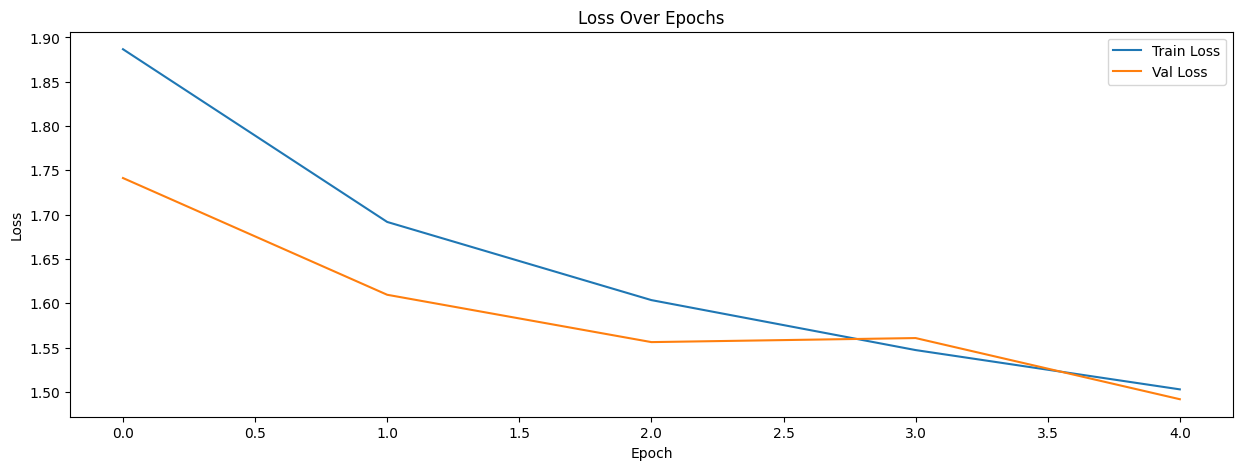

In [34]:
histories = best_config['history']
utils.plot_acc(histories['train_acc'], histories['val_acc'])
utils.plot_loss(histories['train_loss'], histories['val_loss'])

#### Final Attempt
Even though the results of the screening seem ineffective, as all configurations performed similarly and poorly, we can still see that the 5 epochs were not enough for the best configuration to achieve its peak performance, as is evident in the accuracy plot above. As such we will still pick the best configuration and attempt to run it thoroughly with enough iterations to see if it improves.

In [35]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
model = FlexibleFFNN([512, 256]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
histories = train_FFNN(model, trainloader, valloader, crossEntropy_criterion, optimizer, device, epochs=20, early_stopping=True)

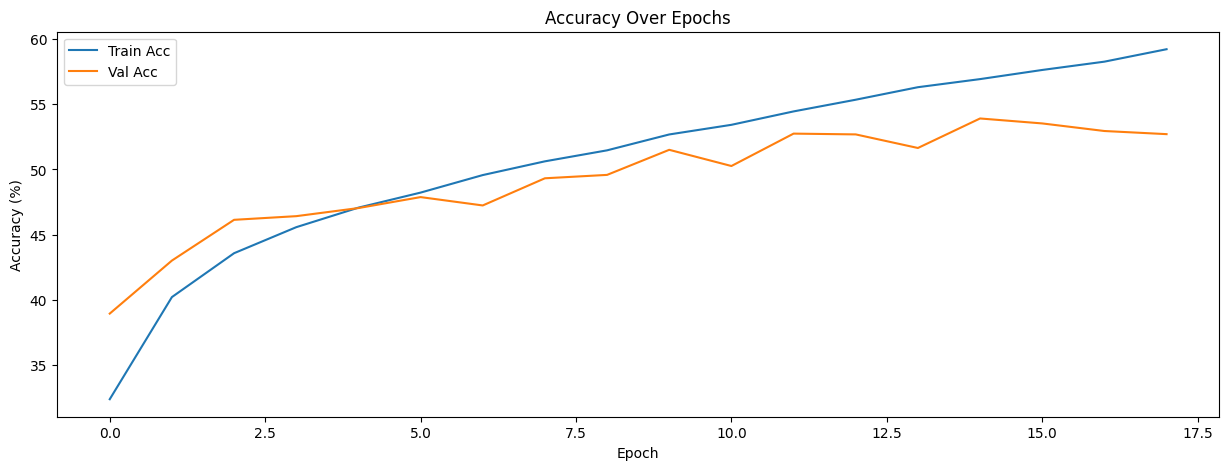

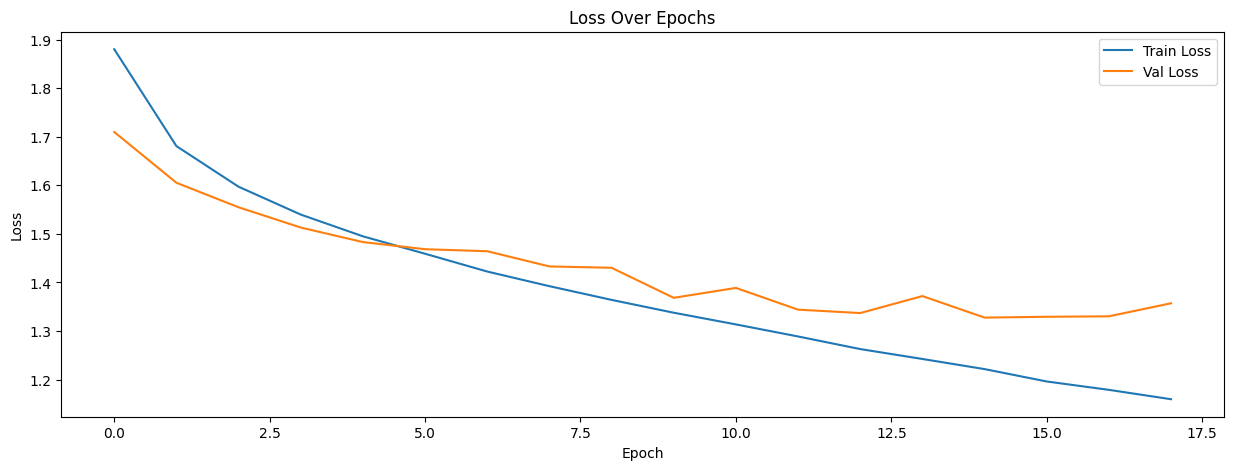

In [36]:
utils.plot_acc(histories['train_acc'], histories['val_acc'])
utils.plot_loss(histories['train_loss'], histories['val_loss'])

Although the slight increase in accuracy was promising, this configuration shows to have the same limitation as the previous ones, as it is cut off during training when it fails to generalize beyond a certain point. None of the configurations managed to reach above 50% accuracy on the validation set.

## Conclusions

In this experiment we have rigorously tested various configurations for fully connected feedforward neural networks (FFNNs) on the CIFAR-10 dataset. Afterwards we screened different learning rates and batch sizes to find the optimal configuration for the FFNN model.

The results clearly showed a limitation of the models: they consistently underfit and struggle to reach above 50% accuracy on the validation set, even after extensive attempts to search for the best configuration. This suggests that FFNNs may not be the best choice for this particular problem, and image recognition in general.

A key intuition of the model's weakness can be gained when considering that the FFNN model has to flatten the image tensor into a single vector of 3072 dimensions. This process loses information about spatial relations, thus harming the model's ability to capture complex patterns in the images. The model does not consider the features at [0,0] and [0,1] as any more related than [0,0] and [32,32], for example, which makes it tough for it to pick up on even simple spatial patterns.

Additionally, FFNNs lack the ability to learn hierarchical representations, which may be crucial for tasks like image classification.

It may be possible to improve the model's performance by making it significantly deeper. However, this is very inefficient and may not be necessary, due to the existence of more complex models such as convolutional neural networks (CNNs) which require significantly less parameters.


In conclusion, while FFNNs are simple and easy to implement, they may not be the best choice for image classification tasks like CIFAR-10, and more complex models such as the CNN are considered necessary to improve performance. This is explored in the following notebooks.